In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model

import numpy as np

Using TensorFlow backend.
/Users/mbp2016/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
img_shape = (28, 28, 1)
batch_size = 16
num_classes = 10
latent_dim = 2

In [3]:
# encoder
input_img = keras.Input(shape=img_shape)
input_lbl_encoder = keras.Input(shape=(num_classes,), dtype='float32')
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.concatenate([x, input_lbl_encoder])

x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [4]:
def sampling(args):
    z_mean, z_log_var = args

    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon


z = layers.Lambda(sampling)([z_mean, z_log_var])

In [5]:
# decoder
decoder_input = keras.Input(shape=K.int_shape(z)[1:])
input_lbl_decoder = keras.Input(shape=(num_classes,), dtype='float32')

x = layers.concatenate([decoder_input, input_lbl_decoder])

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(x)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
decoder = Model([decoder_input, input_lbl_decoder], x)
encoder = Model([input_img, input_lbl_encoder], z)
z_decoded = decoder([z, input_lbl_decoder])

In [6]:
def vae_loss(x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

    return K.mean(xent_loss + kl_loss)

In [7]:
cvae = Model([input_img, input_lbl_encoder, input_lbl_decoder], z_decoded)

In [8]:
cvae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [9]:
cvae.compile(optimizer='rmsprop', loss=vae_loss)

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)

In [ ]:
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=10, batch_size=batch_size, verbose=1)

Epoch 1/10
60000/60000 [==============================] - 316s 5ms/step - loss: 0.1796
Epoch 2/10
31360/60000 [==============>...............] - ETA: 2:19 - loss: 0.1678

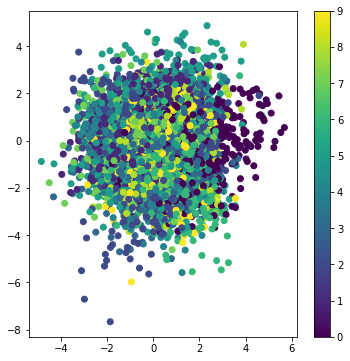

In [14]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict([x_test, y_test_cat], batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

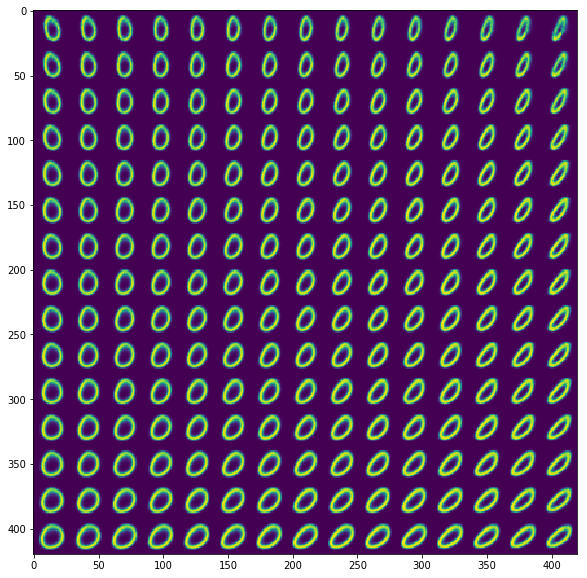

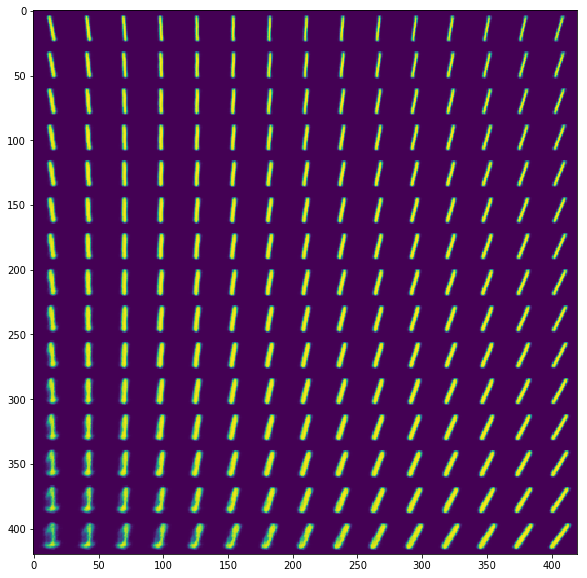

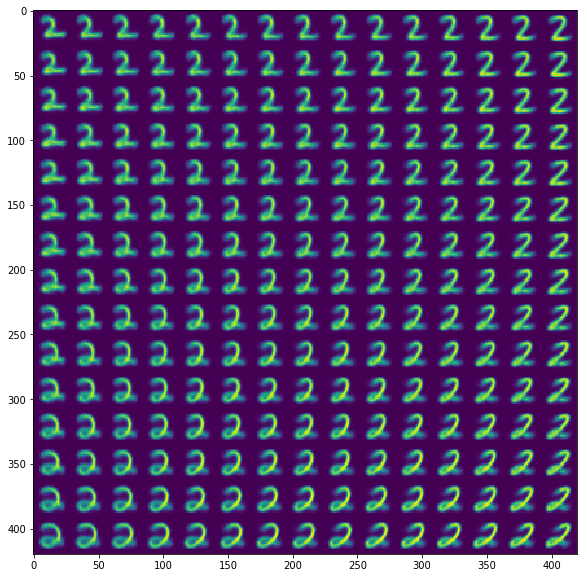

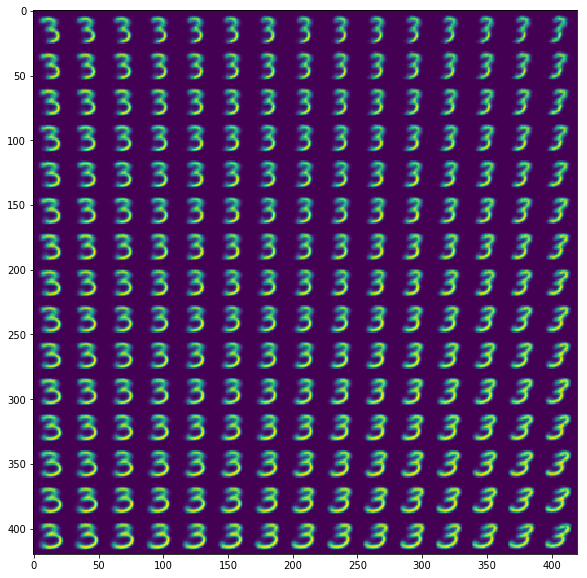

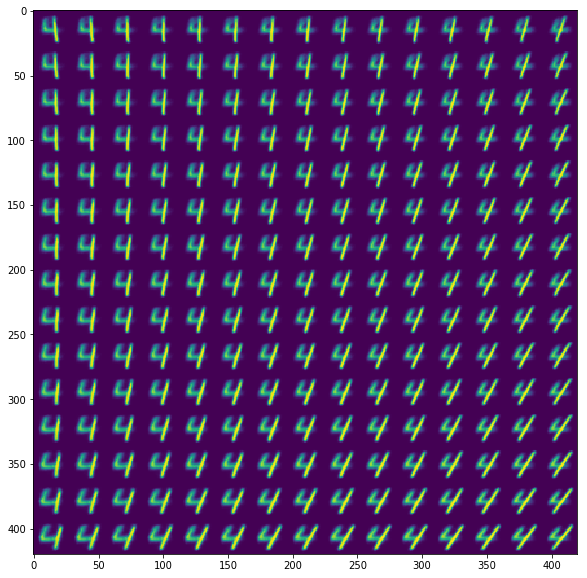

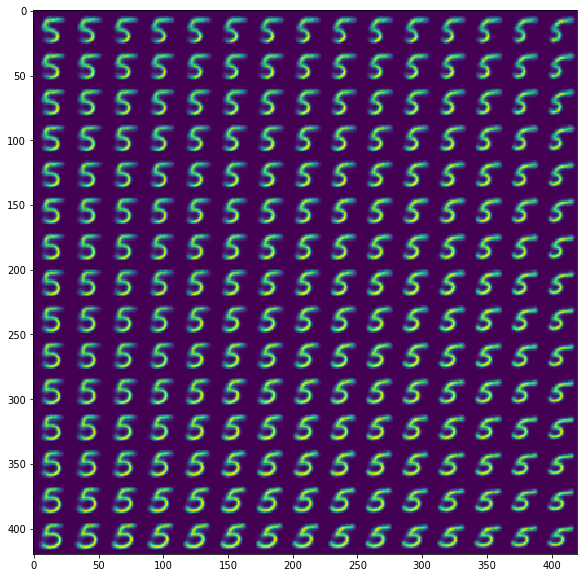

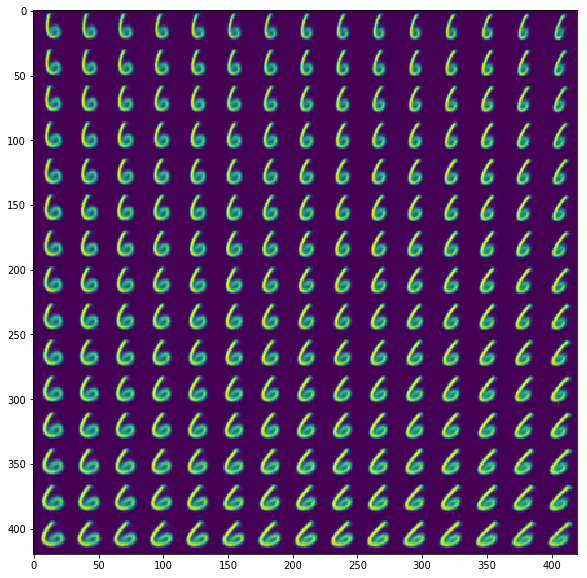

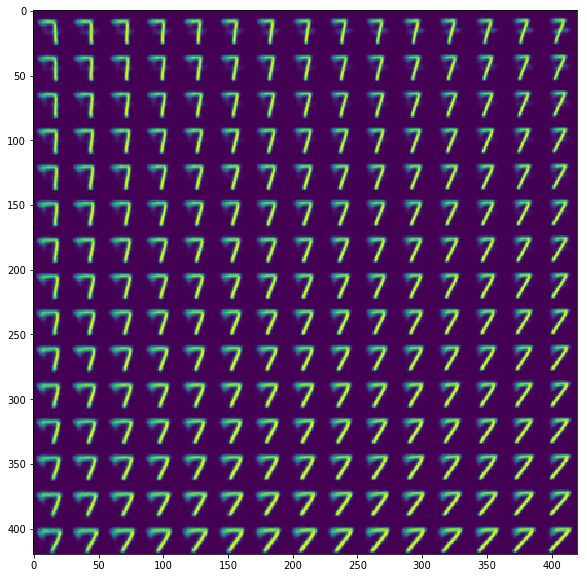

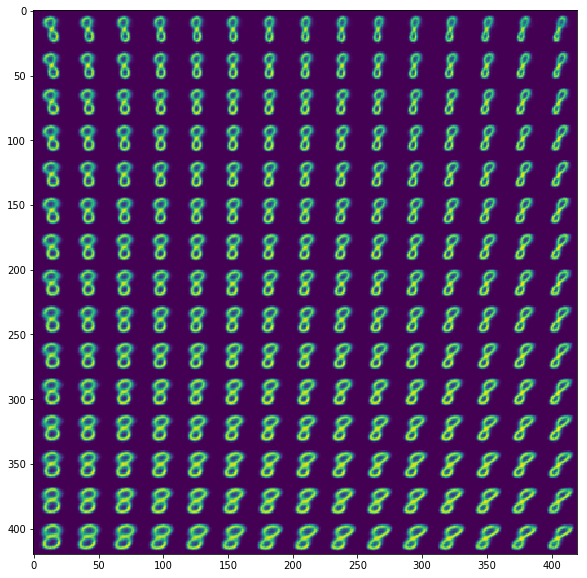

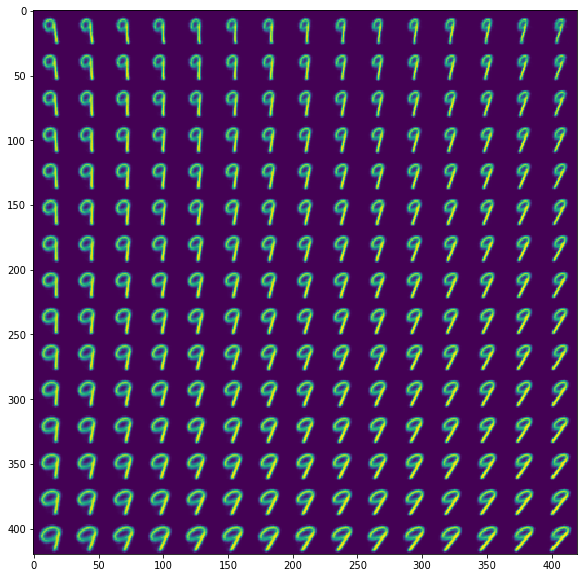

In [15]:
from scipy.stats import norm

n =15
digit_size = 28
fig = np.zeros((digit_size*n, digit_size*n))
grid_x=norm.ppf(np.linspace(0.05, 0.95, n))
grid_y=norm.ppf(np.linspace(0.05, 0.95, n))
for d in range(10):
    for i, xi in enumerate(grid_x):
        for j, yi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            y = np.zeros((1, 10))
            y[0, d] = 1
            x_decoded = decoder.predict([z_sample, y], batch_size=batch_size)
            digit = x_decoded.reshape(digit_size, digit_size)
            fig[i*digit_size:(i+1)*digit_size,
                  j*digit_size:(j+1)*digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(fig)
    plt.show()